# Create a meshed screen with a plane-wave beam

The screen is placed at the origin with the normal pointing (1/sqrt(2), 0, -1/sqrt(2)) <br>
The beam is propagating in positive z direction and would be reflected to positive x direction (left).<br>
The beam is a plane wave but with a gaussian temporal pulse shape.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
from MeshedFields import *

In [7]:
mesh = MeshedField.CircularMesh(R=0.05, ratio=25.0, lcar=0.03)
print("%d points" % len(mesh.points))
print("%d triangles" % len(mesh.triangles))

117108 points
230862 triangles


Modify the points so that the screen is angled 45 degree to the incidence (z-axis) and displaced 1.258m from the origin.

In [8]:
pts = [np.array([p[0],p[1],p[0]+1.258])for p in mesh.points]
target = MeshedField(pts, mesh.triangles)

We check the typical size of the triangles in x and z direction.<br>
This has to be substantially smaller than the wavelength.

0.00135402686858
5.43681343998e-05


(array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.70000000e+02,   6.37000000e+03,   4.68060000e+04,
          7.49830000e+04,   6.43430000e+04,   3.03410000e+04,
          7.16700000e+03,   6.76000000e+02,   6.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00]),
 array([  0.00000000e+00,   7.89473684e-06,   1.57894737e-05,
          2.36842105e-05,   3.15789474e-05,   3.94736842e-05,
          4.73684211e-05,   5.52631579e-05,   6.31578947e-05,
          7.10526316e-05,   7.89473684e-05,   8.68421053e-05,
          9.47368421e-05,   1.02631579e-04,   1.10526316e-04,
          1.18421053e-04,   1.26315789e-04,   1.34210526e-04,
          1.42105263e-04,   1.50000000e-04]),
 <a list of 19 Patch objects>)

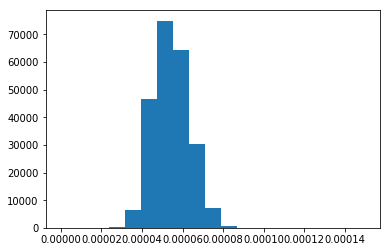

In [9]:
def zsize(id):
    t = target.triangles[id]
    pts = [target.points[ip] for ip in t]
    z = [p[2] for p in pts]
    dz = np.max(z)-np.min(z)
    return dz

def ysize(id):
    t = target.triangles[id]
    pts = [target.points[ip] for ip in t]
    y = [p[1] for p in pts]
    dy = np.max(y)-np.min(y)
    return dy

dy = [ysize(id) for id in range(target.Np)]
print(np.average(dy))
dz = [zsize(id) for id in range(target.Np)]
print(np.average(dz))

plt.hist(dz, bins=np.linspace(0,0.00015,20))

In [6]:
normals = target.MeshNormals()
print(np.sum(normals, axis=0)/target.Np)

[  7.07106781e-01  -2.05590733e-17  -7.07106781e-01]


In [6]:
area = target.MeshArea()
print(np.pi*np.square(0.05)*np.sqrt(2.0))
print(np.sum(area))

0.0111072073454
0.0111063451695


### setup the timing of the cells

The peak of the wave packet is assumed to start at the origin at t=0.

The start time of the traces is 200 steps before the expected time of arrival which is computed as the z coordinate of the observation point divided by the speed of light. The length is 600 steps what accounts for some propagation lines having greater length.

In [10]:
print(1.258/constants.c)

4.196236317592753e-09


In [15]:
# time step
target.dt = 1.0e-13
target.Nt = 500
target.t0 = [p[2]/constants.c -200*target.dt for p in target.pos]
print(np.min(target.t0))
print(np.max(target.t0))
print(len(target.t0))

4.00955005778e-09
4.3429207742e-09
230862


In [16]:
id = 1234
z=target.pos[id][2]
print(z/constants.c)
print(target.t0[id])
print(target.t0[id] + 200*target.dt)

4.08156948517e-09
4.06156948517e-09
4.08156948517e-09


estimated memory requirements

In [17]:
8*target.Np*target.Nt*6

5540688000

## check geometry and write to file

In [11]:
target.ShowMeshedField(showCenters=False,showAxes=True)

In [18]:
filename="AngledTargetFine.h5"
target.WriteMeshedField(filename)

## check the source file

-2e-11
-2e-11
peak energy density = 3.711593 J/m²
total pulse energy = 2364.6 µJ


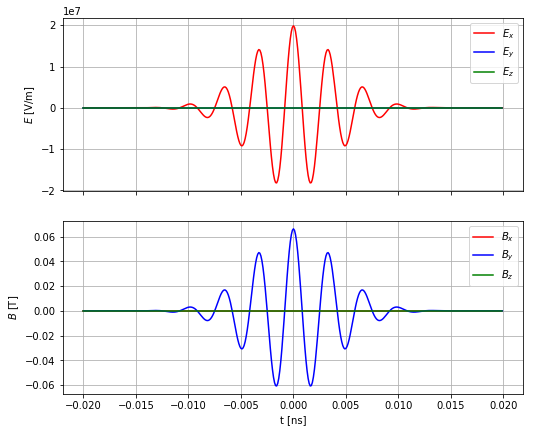

In [2]:
filename="MeshGaussian.h5"
source = MeshedField.ReadMeshedField(filename)

print(np.min(source.t0))
print(np.max(source.t0))

area = source.MeshArea()
P = source.EnergyFlowDensity()
Pz = P[:,2]

print("peak energy density = %.6f J/m²" % np.max(Pz))
print("total pulse energy = %.1f µJ" % (1e6*np.dot(area,Pz)))

source.ShowMeshedField(scalars=Pz,scalarTitle="Pz",highlight=[285])
source.ShowFieldTrace(285)

## check the target file after propagation

4.00979933791e-09
4.3424792717e-09
peak energy density = 1.876205 J/m²
total pulse energy = 3275.7 µJ
cell No. 7397 pos=[  2.68676732e-04  -7.47285223e-04   1.25826868e+00]


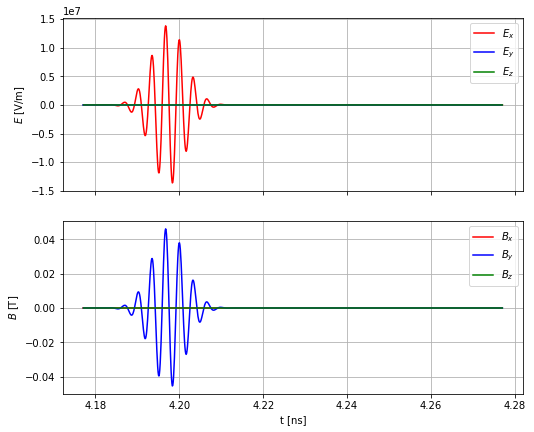

In [19]:
filename="AngledTargetCoarse.h5"
source = MeshedField.ReadMeshedField(filename)

print(np.min(source.t0))
print(np.max(source.t0))

area = source.MeshArea()
P = source.EnergyFlowDensity()
Pz = P[:,2]

print("peak energy density = %.6f J/m²" % np.max(Pz))
print("total pulse energy = %.1f µJ" % (1e6*np.dot(area,Pz)))

def pick(id):
    print("cell No. %d pos=%s" % (id,source.pos[id]))
    source.ShowFieldTrace(id)

source.ShowMeshedField(scalars=Pz,scalarTitle="Pz",pickAction=pick,showGrid=False)